<img src='files/thresher.png' width=300 align='left'>

# Evann Smith, Ph.D.

<b>Senior Data Scientist</b> <br />
evann@thresher.io <br />
http://www.evannsmith.com

# Modeling Text Data

## Unsupervised vs. Supervised Learning

### Supervised
We have training data! <br />
<b>Thresher</b> can get you there quickly :)

- Answering a specific question
- Hypothesis testing
- Prediction

### Unsupervised
We have NO training data.

- Exploration
- Discovery
- Data Mining
- Hypothesis Generation

In [1]:
import numpy as np
import pandas as pd
import random
import string
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm
tqdm.pandas(desc='progress-bar')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from gensim import corpora, models
from tabulate import tabulate
import pyLDAvis.gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
%matplotlib inline 

## Data

### Load the data
- We'll use the Movie Reviews corpus built into NLTK

In [2]:
from nltk.corpus import movie_reviews

### Read the data
- `movie_reviews` is a nltk plain text corpus reader, which will help you conveniently read in the documents in the nltk corpus (make sure that you have run `nltk.download()` to have access to the data!).
- Reviews are categorized as either positive or negative.

In [3]:
reviews = [(movie_reviews.categories(fileid)[0], movie_reviews.raw(fileid)) for fileid in movie_reviews.fileids()]
data = pd.DataFrame(reviews, columns=['category', 'text'])
data.head()

,category,text
0,neg,"plot : two teen couples go to a church party ,..."
1,neg,the happy bastard's quick movie review \ndamn ...
2,neg,it is movies like these that make a jaded movi...
3,neg,""" quest for camelot "" is warner bros . ' firs..."
4,neg,synopsis : a mentally unstable man undergoing ...


In [4]:
data.category.value_counts()

neg    1000
pos    1000
Name: category, dtype: int64

### Preprocess the Data
- Lowercase
- Tokenize
- Remove stop words and punctuation
- Remove words with fewer than 2 characters
- Stem

In [5]:
stop = set(stopwords.words('english') + list(string.punctuation))
stemmer = PorterStemmer()
re_punct = re.compile('[' + ''.join(string.punctuation) + ']')

In [6]:
def preprocess(text):
    try:
        text = text.lower()
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if not t in stop]
        tokens = [re.sub(re_punct, '', t) for t in tokens]
        tokens = [t for t in tokens if len(t) > 2]
        tokens = [stemmer.stem(t) for t in tokens]
        if len(tokens) == 0:
            return None
        else:
            return ' '.join(tokens)
    except:
        return None

In [7]:
data['tokens'] = data['text'].progress_map(preprocess)
data = data[data['tokens'].notnull()]
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

progress-bar: 100%|██████████| 2000/2000 [00:34<00:00, 57.95it/s]


In [8]:
print('{} reviews'.format(len(data)))
data.head()

2000 reviews


,category,text,tokens
0,neg,"plot : two teen couples go to a church party ,...",plot two teen coupl church parti drink drive g...
1,neg,the happy bastard's quick movie review \ndamn ...,happi bastard quick movi review damn y2k bug g...
2,neg,it is movies like these that make a jaded movi...,movi like make jade movi viewer thank invent t...
3,neg,""" quest for camelot "" is warner bros . ' firs...",quest camelot warner bro first featurelength f...
4,neg,synopsis : a mentally unstable man undergoing ...,synopsi mental unstabl man undergo psychothera...


## Supervised Learning for Prediction

- We'll focus on Support Vector Machines (SVMs), which is a type of discriminant model for classification and regression
- They try to find a combination of samples to build a plane maximizing the margin between classes.
- SVMs are a workhorse in supervised classification.
<br /><br />

Advantages:
- Effective in high dimensional spaces.
- Effective in cases where number of dimensions is greater than the number of samples.
- Memory efficient (because it uses a subset of training points in the decision function).
- Versatile (different Kernel functions can be specified for the decision function). 

Disadvantages:
- If the number of features is <b>much</b> greater than the number of samples, performances is likely to be poor.
- SVMs do not directly provide probability estimates, these are calculated using cross-validation.


### Words into numbers
To model text, we need to <b>engineer features</b>. 

- We're going to start with a <b>bag of words</b> approach. (More on other approaches later.)
    - Tokenizing: an integer ID for each unique token
    - Counting: the number of occurrences of each unique token in each document
    - Normalizing: diminish the importance of words that appear in the majority of documents


- We use term frequency-inverse document frequency (tfidf) to normalize and weight our feature representations:

For a term, t, and document, d:

     tfidf(t,d) = tf(t,d) x idf(t)

where tf(t,d) is the frequency of the term in that document, and the idf of the term is:

     idf(t) = log [(1 + n(d)) / (1 + df(d,t))] + 1

where n(d) is the number of total documents and df(d,t) is the number of documents that contain t.

Finally we normalize the document vectors by the Euclidean norm to account for differing document lengths.

In [9]:
texts = data.tokens.tolist()
y = data.category.tolist()
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8)
X = vectorizer.fit_transform(texts)

### Test/Train Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

### Feature Selection
- With text data, the number of features (words) is almost always much larger than the number of samples (documents).
- We want to select the <i>most discriminant</i> features for classification.
- We use Chi2, which calculates the Chi square statistic for each word, relative to class. Chi2 measures the dependence between stochastic variables, so words with a low Chi2 are likely to be independent of class and thus not useful for classifcation. We want to keep the words with the highest Chi2 value.

In [11]:
total_features = len(vectorizer.get_feature_names())
print('{} total features prior to selection'.format(total_features))
ch2 = SelectKBest(chi2, k=500)
X_train = ch2.fit_transform(X_train, y_train)
X_test = ch2.transform(X_test)

9719 total features prior to selection


### Train and Predict

In [12]:
classifier = LinearSVC()
%time classifier.fit(X_train, y_train)
print('Accuracy: {}'.format(round(classifier.score(X_test, y_test), 3)))

CPU times: user 7.83 ms, sys: 1.14 ms, total: 8.97 ms
Wall time: 8.1 ms
Accuracy: 0.818


In [13]:
classifier = RandomForestClassifier()
%time classifier.fit(X_train, y_train)
print('Accuracy: {}'.format(round(classifier.score(X_test, y_test), 3)))

CPU times: user 66.9 ms, sys: 1.44 ms, total: 68.3 ms
Wall time: 70.5 ms
Accuracy: 0.742


In [14]:
classifier = GaussianNB()
%time classifier.fit(X_train.toarray(), y_train)
print('Accuracy: {}'.format(round(classifier.score(X_test.toarray(), y_test), 3)))

CPU times: user 16.4 ms, sys: 7.97 ms, total: 24.4 ms
Wall time: 24.7 ms
Accuracy: 0.695


<br /><br />
## Unsupervised Analysis for Discovery

### Latent Dirichlet Allocation (LDA)

- Generative statistical model 
- Expains similarlites between observations as function of unobserved groups

<br />

For text data:
- Documents are a mixture of topics
    - Topics are assumed to have a sparse Dirichlet prior (capturing the intuition that documents only cover a few topics and topics only use a small set of words frequently)
- Topics are a distribution of words

<br />

Topics are <b>latent structures</b>, which we try to backwards infer from the collection of documents that could have generated them:
- Decide the length of the document, N
- Choose a topic mixture (e.g., 1/3 about zombies and 2/3 about romance) from a Dirichlet distribution with K fixed topics
- Generate each word in the document by:
    - Pick a topic according to the distribution sampled above
    - Pick a word according to the topic's distribution of words

<br />

To learn the topics and words (collapsed Gibbs Sampling):
- Randomly assign each word in each document to a topic K
    - This gives you (bad) topic representations of all documents and word distributions of all topics
- Improve for each word in each document by:
    - Assuming that all topic assignments except for the current word are correct and update the assignment of the current word using the generative model
    - Rinse, repeat until you reach a "steady state"

### Prepare the Data
- Use `TfidfVectorizer` to remove non-informative words
- Convert to a `gensim` corpus

In [15]:
texts = data.tokens.tolist()
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8)
X = vectorizer.fit_transform(texts)
vocab = vectorizer.vocabulary_
idf = vectorizer.idf_

In [16]:
np.percentile(idf, [0, 25, 50, 75, 1])

array([ 1.2625142 ,  4.99048442,  5.89335213,  6.52196079,  2.23383371])

In [17]:
vocab_keep = np.where(idf >= np.percentile(idf, 50))[0]

In [18]:
vocab = [k for k,v in vocab.items() if v in vocab_keep]
print('{} words in the vocabulary'.format(len(vocab)))

5007 words in the vocabulary


In [19]:
texts = [[token for token in tokens.split() if token in vocab] for tokens in data.tokens]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

In [20]:
print(corpus[0])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1)]


In [21]:
corpora.MmCorpus.serialize('reviews.mm', corpus)
id2word.save('reviews.dict')

### Cross-Validated LDA
The existential question: <b>How many topics?</b>

- Theoretical validation
    - No substitute for substantive expertise
- Empirical validation on held-out data
    - We want to minimize perplexity, which is a decreasing function of the log-likelihood on unseen documents. (The higher the log-liklihood on unseen documents, the better the model.)

<b>CAVEAT 1:</b> The statistically optimal empirical solution may not be the theoretically optimal solution. Estimating the optimal mixture of distributions is not the same thing as estimating the number of "cohesive and well-separated from other data" ideas (Baudry et al. 2010; also see Biernacki, 2000). <br />
<br />
<b>CAVEAT 2:</b> Perplexity is not strongly correlated with human judgement (Chang et al., 2009).

In [22]:
def ldaCV(n_topics, corpus, id2word, test_size=0.2, sample=None):
    if not isinstance(n_topics, list):
        n_topics = [n_topics]
    obs = len(corpus)
    corpus = np.array(corpus)
    
    if sample is not None:
        if sample < 1:
            sample_idx = random.sample(range(obs), int(obs*sample))
        else:
            sample_idx = random.sample(range(obs), int(sample))
        corpus = corpus[sample_idx]
    
    train, test = train_test_split(corpus, test_size=test_size, random_state=12345)
    perplexities = []
    
    for n in n_topics:
        print('{} topics'.format(n))
        model = models.ldamodel.LdaModel(train, num_topics=n, id2word=id2word, random_state=12345)
        perplexity = model.log_perplexity(test)       
        print(' - Perplexity: {}'.format(round(perplexity, 3)))
        perplexities.append((n, perplexity))
    
    return perplexities    

In [23]:
%time p = ldaCV(list(range(5, 55, 5)), corpus, id2word)

5 topics
 - Perplexity: -10.71
10 topics
 - Perplexity: -12.466
15 topics
 - Perplexity: -13.793
20 topics
 - Perplexity: -14.884
25 topics
 - Perplexity: -15.751
30 topics
 - Perplexity: -16.538
35 topics
 - Perplexity: -17.201
40 topics
 - Perplexity: -17.814
45 topics
 - Perplexity: -18.233
50 topics
 - Perplexity: -18.747
CPU times: user 2min 3s, sys: 1.07 s, total: 2min 4s
Wall time: 2min 10s


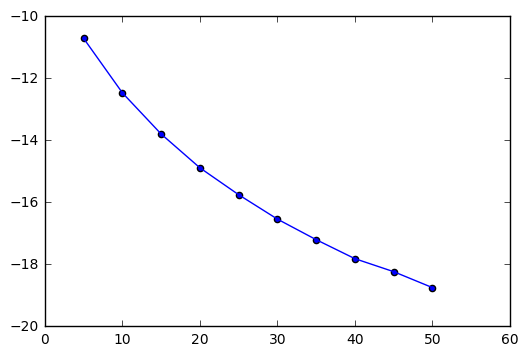

In [24]:
x, y = zip(*p)
plt.plot(x, y)
plt.scatter(x, y)
plt.show()

### Full Model

In [25]:
model = models.ldamodel.LdaModel(corpus, num_topics=20, id2word=id2word, random_state=12345)

In [26]:
model.save('reviews_20_lda.model')

### View Top Topic Words
- View the top 5 words associated with 10 random topics.
- The number is the weight of the word it is multiplying (i.e., how much does this word influence the particular topic). 

In [27]:
model.print_topics(num_topics=10, num_words=5)

[(15,
  '0.006*"mulan" + 0.005*"boiler" + 0.005*"spencer" + 0.005*"metro" + 0.005*"josi"'),
 (5,
  '0.013*"flubber" + 0.007*"carlito" + 0.006*"gladiat" + 0.006*"bulworth" + 0.006*"gorilla"'),
 (19,
  '0.010*"anaconda" + 0.008*"ordel" + 0.006*"dolor" + 0.005*"hewitt" + 0.005*"lambeau"'),
 (8,
  '0.009*"pauli" + 0.004*"crawford" + 0.004*"shyamalan" + 0.004*"cindi" + 0.004*"mccabe"'),
 (14,
  '0.017*"shrek" + 0.008*"8mm" + 0.007*"fiona" + 0.007*"hammer" + 0.006*"frequenc"'),
 (13,
  '0.006*"insurrect" + 0.006*"robocop" + 0.006*"felix" + 0.005*"dora" + 0.005*"judith"'),
 (11,
  '0.009*"farrelli" + 0.008*"iren" + 0.005*"1900" + 0.005*"raimi" + 0.004*"mermaid"'),
 (3,
  '0.010*"bulworth" + 0.009*"sonni" + 0.007*"margaret" + 0.007*"hamlet" + 0.007*"apostl"'),
 (12,
  '0.007*"robocop" + 0.005*"col" + 0.005*"kelley" + 0.005*"sherri" + 0.005*"beau"'),
 (0,
  '0.018*"mulan" + 0.011*"whale" + 0.004*"melvin" + 0.003*"mamet" + 0.003*"buster"')]

### Query the Model With New Text
- Credit to http://christop.club/2014/05/06/using-gensim-for-lda/

In [28]:
query = "I love the movie Shrek. The donkey is hilarious. It is much better than the old Disney films."
query = preprocess(query).split()

In [29]:
query = id2word.doc2bow(query)
print(query)

[(4866, 1), (4867, 1)]


In [30]:
topic_relevance = list(sorted(model[query], key=lambda x: -x[1]))
print('Most relevant: {}'.format(topic_relevance[0]))
print('Least relevant: {}'.format(topic_relevance[-1]))

Most relevant: (14, 0.68333333318392886)
Least relevant: (19, 0.01666666666666667)


In [31]:
model.print_topic(topic_relevance[0][0]) # most related

'0.017*"shrek" + 0.008*"8mm" + 0.007*"fiona" + 0.007*"hammer" + 0.006*"frequenc" + 0.006*"donkey" + 0.006*"farquaad" + 0.005*"snuff" + 0.005*"bowfing" + 0.004*"muppet"'

In [32]:
model.print_topic(topic_relevance[-1][0]) # least related

'0.010*"anaconda" + 0.008*"ordel" + 0.006*"dolor" + 0.005*"hewitt" + 0.005*"lambeau" + 0.005*"bruckheim" + 0.004*"ripley" + 0.004*"crab" + 0.004*"carlito" + 0.004*"gellar"'

### Visualize the Model
- http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb#topic=0&lambda=1&term=

In [33]:
id2word = corpora.Dictionary.load('reviews.dict')
corpus = corpora.MmCorpus('reviews.mm')
model = models.ldamodel.LdaModel.load('reviews_20_lda.model')

In [34]:
reviews_vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
pyLDAvis.display(reviews_vis)

<br />
## Semi Supervised Analysis to Exploit Semantic Relationships

### Feature Engineering
There are two big "classes" of approaches:
- Count-based (bag of words):
    - Each word is represented with a single number ("one-hot" representation)
    - Very fast, easy to understand (and often outperform more complex solutions on small to medium data)
    - Treats documents as "bags of words"
        - Loses semantic and syntactic context
        - Bad with words that are rare in the training set

<br />
- Word embeddings:
    - Each word is represented by a dense vector of continuous values
    - Seems to capture semantic and syntactic relationships, though we don't fully understand why (Goldberg and Levy 2014)
        - The hypothesis is that words in similar contexts have similar meanings
    - Requires a lot of training data
    - Bad with words that are rare across the entire corpus

There are many implementations:
- Stanford's GloVE (https://nlp.stanford.edu/projects/glove/)
- Facebook FastText (https://github.com/facebookresearch/fastText)
- Word2Vec (Mikolov et al. 2013)
<br /><br />

Some evidence suggests FastText may be better at syntactic relationships, while Word2Vec may be better at semantic relationships. <br />

Additional evidence emphasizes the importance of domain specific embeddings (Hamilton et al., 2016). ("Soft" means something very different when talking about fuzzy animals vs. sports.)

### Word2Vec and Doc2Vec
 - Train a simple neural network with a single hidden layer
 - Use the weights of the hidden layer as “word vectors”

<br />

<b>Word2Vec</b> (as we use it) captures context through skipgrams, built from sequences of text in a document:
- Uses a hidden layer to produce a projection of a word in context
- Weights are optimized based on context words, embedding the distribution over context words in the representation of the center word

<img src='files/skip-gram.png' width="500" align='center'>
http://zhangbanger.github.io/2015/12/13/allen-ai-challenge-part-3.html

<br />
<b>Doc2Vec</b> jointly estimates word vectors and document vectors (Le and Mikolov, 2014)

### Prep the Data
- Tag the documents and create the labels

In [35]:
y = []
doc_vectors = []
for i, row in data.iterrows():
    doc_vectors.append(TaggedDocument(row['tokens'].split(), ['doc_' + str(i)]))
    y.append(row['category'])
print(len(y), len(doc_vectors))

2000 2000


### Train the Word Embeddings (The Unsupervised Part)

In [36]:
def shuffle_docs(docs):
    random.shuffle(docs)
    return docs

In [37]:
token_count = sum([len(doc_vector) for doc_vector in doc_vectors])
model = Doc2Vec(size=100, window=10, min_count=1, workers=4)
model.build_vocab(doc_vectors)
for epoch in range(20):
    print('Epoch {}'.format(epoch))
    model.train(shuffle_docs(doc_vectors), total_examples=token_count, epochs=1)
d2v = {d: vec for d, vec in zip(model.docvecs.offset2doctag, model.docvecs.doctag_syn0)}
X = []
for d in range(len(doc_vectors)):
    X.append(d2v['doc_' + str(d)])
X = np.array(X)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [38]:
model.save('reviews_doc2vec.model')

In [39]:
model = Doc2Vec.load('reviews_doc2vec.model')

In [40]:
d2v = {d: vec for d, vec in zip(model.docvecs.offset2doctag, model.docvecs.doctag_syn0)}
X = []
for d in range(len(doc_vectors)):
    X.append(d2v['doc_' + str(d)])
X = np.array(X)

In [41]:
model.most_similar('good')

[('decent', 0.5797518491744995),
 ('mcgann', 0.4261823296546936),
 ('dolittl', 0.42150282859802246),
 ('niftiest', 0.39561766386032104),
 ('poor', 0.39115533232688904),
 ('perfectli', 0.38975512981414795),
 ('backandforth', 0.3866485357284546),
 ('amaz', 0.3853611946105957),
 ('tough', 0.38419878482818604),
 ('miniatur', 0.3829454779624939)]

In [42]:
model.most_similar('horribl')

[('terribl', 0.5605968832969666),
 ('cruddi', 0.5057984590530396),
 ('horrif', 0.44955626130104065),
 ('lastminut', 0.4449557662010193),
 ('hokey', 0.4345216751098633),
 ('corni', 0.42026379704475403),
 ('coloss', 0.4185634255409241),
 ('jawdroppingli', 0.4184514284133911),
 ('gobetween', 0.4174378514289856),
 ('ruin', 0.4078148305416107)]

<img src='files/word2vecqueen.png' width="500" align='center'>
http://blog.christianperone.com/2016/01/voynich-manuscript-word-vectors-and-t-sne-visualization-of-some-patterns/

In [43]:
model.most_similar(positive=['woman', 'actor'], negative=['man'])

[('actress', 0.4704681932926178),
 ('nuanc', 0.40951240062713623),
 ('talent', 0.37572893500328064),
 ('tolkan', 0.3689042329788208),
 ('judd', 0.3588447868824005),
 ('gena', 0.353010892868042),
 ('fraser', 0.3452267646789551),
 ('bitingli', 0.3444317877292633),
 ('onscreen', 0.3393170237541199),
 ('ashley', 0.3369916081428528)]

### Train and Test the Classifier (The Supervised Part)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [45]:
classifier = LinearSVC()
classifier.fit(x_train, y_train)
print('Accuracy: {}'.format(round(classifier.score(x_test, y_test), 3)))

Accuracy: 0.802
